In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from textblob import TextBlob
import re

# # Download NLTK required resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/wuqinyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuqinyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# data input
df = pd.read_excel("/Users/wuqinyu/Desktop/NUS课程/sem2/QF5214周一/project/xdata_merge3.xlsx")
#Added tweet-date column
df['tweet_time'] = pd.to_datetime(df['tweet_time'])
df['tweet_date'] = df['tweet_time'].dt.date
#Added a new column:Definition: interaction=likes+2*comments+3*reposts+4*favorites
df['interact_count'] = df['like_count']+2*df['reply_count']+3*df['retweet_count']+4*df['bookmark_count']


In [ ]:
#Divide the data set into 10-day periods
start_date1 = pd.to_datetime('2025-03-16').date()
end_date1 = pd.to_datetime('2025-03-25').date()
df1= df[(df['tweet_date'] >= start_date1) & (df['tweet_date'] <= end_date1)]
start_date2 = pd.to_datetime('2025-03-26').date()
end_date2 = pd.to_datetime('2025-04-04').date()
df2= df[(df['tweet_date'] >= start_date2) & (df['tweet_date'] <= end_date2)]


In [ ]:
#Create stop words
stop_words = set(stopwords.words('english'))
custom_stopwords = set([
    'people', 'think', 'today', 'make', 'see', 'like', 'get', 'got', 'just',
    'one', 'know', 'way', 'looks', 'really', 'thing', 'could', 'would',
    'need', 'going', 'let', 'even', 'good', 'great', 'much', 'still', 'well','that',
    'they','are','thats','us','im','time','years','dont','isnt','lot',
    'real','every','put','ago','year','many','lets','youre',
    'us','new','since','think', 'market','get','price','join','using','day',
    'daily','one','like','k','x','nan','im','week','going', 'people','time','first',
    'next','would','could','today','year','make','every',
    'top','data','best','big','right','coming','million','back','makets','trading',
    'days','also','go','full','last','check','buy','markets',
    'making','building','launch','soon','march','future','live','call','says','soon','holders'
])
all_stopwords = list(stop_words.union(custom_stopwords))

### Keyword performance in last period cycle

In [108]:
# Preprocessing: Cleaning the Text
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r"http\S+", "", text)  # Remove Link
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()
    return text

df1['clean_tweet'] = df1['tweet_text'].apply(clean_text)
df1['clean_replies'] = df1['top_replies'].apply(clean_text)

# Tokenize and remove stop words
stop_words = all_stopwords
def extract_keywords(text):
    words = word_tokenize(text)
    keywords = [w for w in words if w not in stop_words and w.isalpha()]
    return keywords

df1['tweet_keywords'] = df1['clean_tweet'].apply(extract_keywords)
df1['reply_keywords'] = df1['clean_replies'].apply(extract_keywords)

# Extract the frequency of all keywords
all_keywords = sum(df1['tweet_keywords'].tolist(), [])
top50_keywords = [w for w, _ in Counter(all_keywords).most_common(50)]
# Save the frequency of keywords
keyword_frequency = dict(Counter(all_keywords).most_common(50))


# Initialize the statistics dictionary
stats = {}

# Build keyword analysis
for keyword in top50_keywords:
    rows_with_kw = df1[df1['tweet_keywords'].apply(lambda x: keyword in x)]
    replies_with_kw = rows_with_kw['reply_keywords'].tolist()
    flattened_replies = sum(replies_with_kw, [])

    # Comment keyword frequency
    reply_kw_freq = Counter(flattened_replies).most_common(15)

    # Sentiment Analysis
    pos_words = []
    neg_words = []
    polarity_list = []

    for reply in rows_with_kw['clean_replies']:
        if isinstance(reply, str) and len(reply.strip()) > 0:
            blob = TextBlob(reply)
            polarity = blob.sentiment.polarity
            polarity_list.append(polarity)
            if polarity > 0:
                pos_words += extract_keywords(reply)
            elif polarity < 0:
                neg_words += extract_keywords(reply)

    pos_count = len([p for p in polarity_list if p > 0])
    neg_count = len([p for p in polarity_list if p < 0])
    total_count = len(polarity_list)

    stats[keyword] = {
        "Keyword Frequency": keyword_frequency.get(keyword, 0),  # 加入关键词频次
        "Top 10 Comment Keywords": reply_kw_freq,
        "Number of Tweets with Keyword": len(rows_with_kw),
        "Number of Comments with Keyword": sum(rows_with_kw['reply_count']),
        "Comment Keyword Dictionary": dict(reply_kw_freq),
        "Positive Comment Keywords": Counter(pos_words).most_common(10),
        "Negative Comment Keywords": Counter(neg_words).most_common(10),
        "Positive Comment Ratio": pos_count / total_count if total_count > 0 else 0,
        "Negative Comment Ratio": neg_count / total_count if total_count > 0 else 0,
        "Total Sentiment Ratio (Pos+Neg)": (pos_count + neg_count) / total_count if total_count > 0 else 0,
        "Avg Likes": rows_with_kw['like_count'].mean(),
        "Avg Comments": rows_with_kw['reply_count'].mean(),
        "Avg Retweets": rows_with_kw['retweet_count'].mean(),
        "Avg Bookmarks": rows_with_kw['bookmark_count'].mean(),
        "Avg Engagement": rows_with_kw['interact_count'].mean()
    }

# Convert to DataFrame for viewing or saving
results_df1 = pd.DataFrame(stats).T  
results_df1.reset_index(inplace=True)
results_df1.rename(columns={"index": "Keyword"}, inplace=True)

# Show part of results
print(results_df1.head(10))
results_df1.to_excel("topwords1.xlsx", index=False)


/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/3282146321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_tweet'] = df1['tweet_text'].apply(clean_text)
/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/3282146321.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_replies'] = df1['top_replies'].apply(clean_text)
/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/3282146321.py:20: SettingWithCopyWarning: 
A value is trying to be set o

   Keyword Keyword Frequency  \
0  bitcoin               182   
1   crypto               167   
2    token                57   
3    trump                55   
4      btc                46   
5       ai                44   
6   solana                43   
7  bullish                43   
8    chain                40   
9  billion                35   

                             Top 10 Comment Keywords  \
0  [(bitcoin, 148), (btc, 35), (crypto, 27), (bit...   
1  [(crypto, 95), (ai, 66), (bitcoin, 27), (defi,...   
2  [(ai, 47), (token, 23), (defi, 14), (bsc, 13),...   
3  [(crypto, 18), (bitcoin, 17), (trump, 12), (de...   
4  [(bitcoin, 27), (btc, 13), (bitcoins, 10), (de...   
5  [(ai, 107), (creation, 22), (content, 22), (bs...   
6  [(solana, 38), (crypto, 8), (apis, 7), (token,...   
7  [(bullish, 33), (deposit, 8), (ready, 6), (mom...   
8  [(abstraction, 17), (chain, 16), (chains, 8), ...   
9  [(crypto, 9), (solana, 8), (tokenization, 7), ...   

  Number of Tweets with Keywor

### Keyword performance in current period cycle

In [109]:
# Preprocessing: Cleaning the Text
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r"http\S+", "", text)  # Remove Link
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()
    return text

df2['clean_tweet'] = df2['tweet_text'].apply(clean_text)
df2['clean_replies'] = df2['top_replies'].apply(clean_text)

# Tokenize and remove stop words
stop_words = all_stopwords
def extract_keywords(text):
    words = word_tokenize(text)
    keywords = [w for w in words if w not in stop_words and w.isalpha()]
    return keywords

df2['tweet_keywords'] = df2['clean_tweet'].apply(extract_keywords)
df2['reply_keywords'] = df2['clean_replies'].apply(extract_keywords)

# Extract the frequency of all keywords
all_keywords = sum(df2['tweet_keywords'].tolist(), [])
top50_keywords = [w for w, _ in Counter(all_keywords).most_common(50)]
# Save the frequency of keywords
keyword_frequency = dict(Counter(all_keywords).most_common(50))


# Initialize the statistics dictionary
stats = {}

# Build keyword analysis
for keyword in top50_keywords:
    rows_with_kw = df2[df2['tweet_keywords'].apply(lambda x: keyword in x)]
    replies_with_kw = rows_with_kw['reply_keywords'].tolist()
    flattened_replies = sum(replies_with_kw, [])

    # Comment keyword frequency
    reply_kw_freq = Counter(flattened_replies).most_common(15)

    # Sentiment Analysis
    pos_words = []
    neg_words = []
    polarity_list = []

    for reply in rows_with_kw['clean_replies']:
        if isinstance(reply, str) and len(reply.strip()) > 0:
            blob = TextBlob(reply)
            polarity = blob.sentiment.polarity
            polarity_list.append(polarity)
            if polarity > 0:
                pos_words += extract_keywords(reply)
            elif polarity < 0:
                neg_words += extract_keywords(reply)

    pos_count = len([p for p in polarity_list if p > 0])
    neg_count = len([p for p in polarity_list if p < 0])
    total_count = len(polarity_list)

    stats[keyword] = {
        "Keyword Frequency": keyword_frequency.get(keyword, 0),  # 加入关键词频次
        "Top 10 Comment Keywords": reply_kw_freq,
        "Number of Tweets with Keyword": len(rows_with_kw),
        "Number of Comments with Keyword": sum(rows_with_kw['reply_count']),
        "Comment Keyword Dictionary": dict(reply_kw_freq),
        "Positive Comment Keywords": Counter(pos_words).most_common(10),
        "Negative Comment Keywords": Counter(neg_words).most_common(10),
        "Positive Comment Ratio": pos_count / total_count if total_count > 0 else 0,
        "Negative Comment Ratio": neg_count / total_count if total_count > 0 else 0,
        "Total Sentiment Ratio (Pos+Neg)": (pos_count + neg_count) / total_count if total_count > 0 else 0,
        "Avg Likes": rows_with_kw['like_count'].mean(),
        "Avg Comments": rows_with_kw['reply_count'].mean(),
        "Avg Retweets": rows_with_kw['retweet_count'].mean(),
        "Avg Bookmarks": rows_with_kw['bookmark_count'].mean(),
        "Avg Engagement": rows_with_kw['interact_count'].mean()
    }

# Convert to DataFrame for viewing or saving
results_df2 = pd.DataFrame(stats).T  
results_df2.reset_index(inplace=True)
results_df2.rename(columns={"index": "Keyword"}, inplace=True)

# Show part of results
print(results_df2.head(10))
results_df2.to_excel("topwords2.xlsx", index=False)

/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/4195530116.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_tweet'] = df2['tweet_text'].apply(clean_text)
/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/4195530116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_replies'] = df2['top_replies'].apply(clean_text)
/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/4195530116.py:20: SettingWithCopyWarning: 
A value is trying to be set o

      Keyword Keyword Frequency  \
0      crypto               328   
1     bitcoin               261   
2   sentiment               244   
3       stats               159   
4     cryptos               126   
5       crowd                90   
6  smartmoney                90   
7          ai                75   
8     bullish                75   
9       trump                69   

                             Top 10 Comment Keywords  \
0  [(crypto, 204), (sentiment, 185), (cryptos, 13...   
1  [(bitcoin, 183), (crypto, 42), (btc, 40), (ana...   
2  [(sentiment, 192), (cryptos, 141), (crypto, 11...   
3  [(sentiment, 124), (cryptos, 94), (stats, 72),...   
4  [(sentiment, 120), (cryptos, 92), (crypto, 68)...   
5  [(sentiment, 12), (cryptos, 10), (bearish, 8),...   
6  [(sentiment, 12), (cryptos, 10), (bearish, 8),...   
7  [(ai, 65), (sonic, 16), (bitcoin, 10), (decent...   
8  [(sentiment, 38), (crypto, 28), (cryptos, 24),...   
9  [(trump, 37), (tariffs, 19), (crypto, 16), (ta...  

### Calculate the growth rate compared to last week

In [ ]:
import pandas as pd


# First rename the fields of df1, adding the suffix last period to represent "last week's data"
df1_renamed = results_df1.rename(columns={
    'Keyword Frequency': 'Keyword Frequency (Last Period)',
    'Avg Likes': 'Avg Likes (Last Period)',
    'Avg Comments': 'Avg Comments (Last Period)',
    'Avg Retweets': 'Avg Retweets (Last Period)',
    'Avg Engagement': 'Avg Engagement (Last Period)'
})

'Keyword', 'Keyword Frequency (Last Period)', 'Avg Likes (Last Period)', 'Avg Comments (Last Period)','Avg Retweets (Last Period)','Avg Engagement (Last Period)'

# Merge df1_renamed onto df2, aligning by "keywords"
df_merged = results_df2.merge(df1_renamed[[
    'Keyword', 'Keyword Frequency (Last Period)', 'Avg Likes (Last Period)', 'Avg Comments (Last Period)','Avg Retweets (Last Period)','Avg Engagement (Last Period)'
   
    ]], 
                      on='Keyword', how='left')

# Fill in missing last week with 0 (indicates new words)
df_merged.fillna(0, inplace=True)

# Calculate the growth rate: this week / last week - 1 ( avoid division by 0 errors)
def growth_rate(current, last):
    return ((current - last) / last) if last != 0 else float('inf')  # # New keywords are considered as positive infinite growth

# Applying the growth rate calculation
df_merged['Keyword Frequency Growth Rate'] = df_merged.apply(lambda row: growth_rate(row['Keyword Frequency'], row['Keyword Frequency (Last Period)']), axis=1)
df_merged['Like Growth Rate'] = df_merged.apply(lambda row: growth_rate(row['Avg Likes'], row['Avg Likes (Last Period)']), axis=1)
df_merged['Comment Growth Rate'] = df_merged.apply(lambda row: growth_rate(row['Avg Comments'], row['Avg Comments (Last Period)']), axis=1)
df_merged['Retweet Growth Rate'] = df_merged.apply(lambda row: growth_rate(row['Avg Retweets'], row['Avg Retweets (Last Period)']), axis=1)
df_merged['Engagement Growth Rate'] = df_merged.apply(lambda row: growth_rate(row['Avg Engagement'], row['Avg Engagement (Last Period)']), axis=1)

# Sort by "Keyword Frequency Growth Rate" in descending order
df_sorted = df_merged.sort_values(by='Keyword Frequency Growth Rate', ascending=False)
df_sorted.to_excel('Keyword_growth_analysis.xlsx', index=False)

/var/folders/sn/_3pgm8td1vb4tbpdjtqx2pph0000gn/T/ipykernel_13433/1514096197.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged.fillna(0, inplace=True)


### New Top10 Trending Keywords

In [122]:
# # Filter out rows where 'keyword frequency (last period)' is 0
#df_new = df_sorted[df_sorted['Keyword Frequency (Last Period)'] == 0]
df_new = df_sorted[
    (df_sorted['Keyword Frequency (Last Period)'] == 0) &
    (df_sorted['Keyword'] != 'cryptos')
]

# Take the top 10 data of 'keyword frequency' (indicates new words that have become popular this week)
df_top10_new = df_new.sort_values(by='Keyword Frequency', ascending=False).head(10)

# Print and view results
print(df_top10_new)
df_top10_new.to_excel('top10_new_keywords.xlsx', index=False)


       Keyword Keyword Frequency  \
2    sentiment               244   
3        stats               159   
6   smartmoney                90   
5        crowd                90   
10     tariffs                67   
14   bearishmp                52   
16     bearish                48   
17         bnb                44   
19   bullishmp                38   
21     deposit                37   

                              Top 10 Comment Keywords  \
2   [(sentiment, 192), (cryptos, 141), (crypto, 11...   
3   [(sentiment, 124), (cryptos, 94), (stats, 72),...   
6   [(sentiment, 12), (cryptos, 10), (bearish, 8),...   
5   [(sentiment, 12), (cryptos, 10), (bearish, 8),...   
10  [(tariffs, 42), (bitcoin, 13), (trade, 10), (t...   
14                                                 []   
16  [(sentiment, 37), (cryptos, 26), (crypto, 20),...   
17  [(bnb, 20), (ai, 13), (greenfield, 10), (witho...   
19  [(sentiment, 12), (cryptos, 10), (bearish, 8),...   
21  [(deposit, 69), (link, 50), (

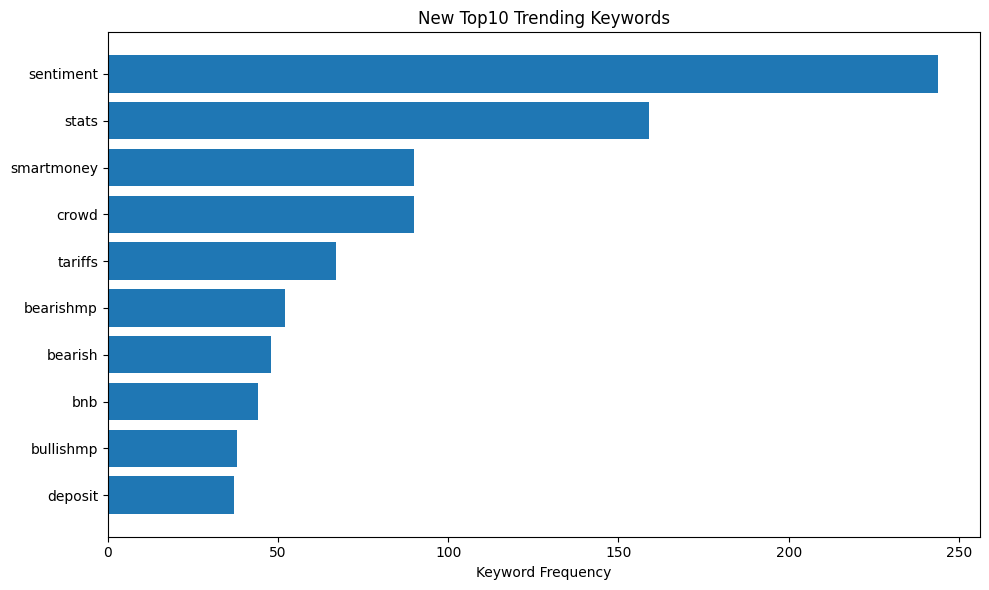

In [119]:
import matplotlib.pyplot as plt

#Sort by keyword frequency in descending order (to prevent the original data from being in the wrong order)
df_plot = df_top10_new.sort_values(by='Keyword Frequency', ascending=False)

# Prepare the data
keywords = df_plot['Keyword']
frequencies = df_plot['Keyword Frequency']

# plot 
plt.figure(figsize=(10, 6))
plt.barh(keywords, frequencies)
plt.xlabel("Keyword Frequency")
plt.title("New Top10 Trending Keywords") #
plt.gca().invert_yaxis()  # Put the most frequent keywords at the top
plt.tight_layout()
plt.show()


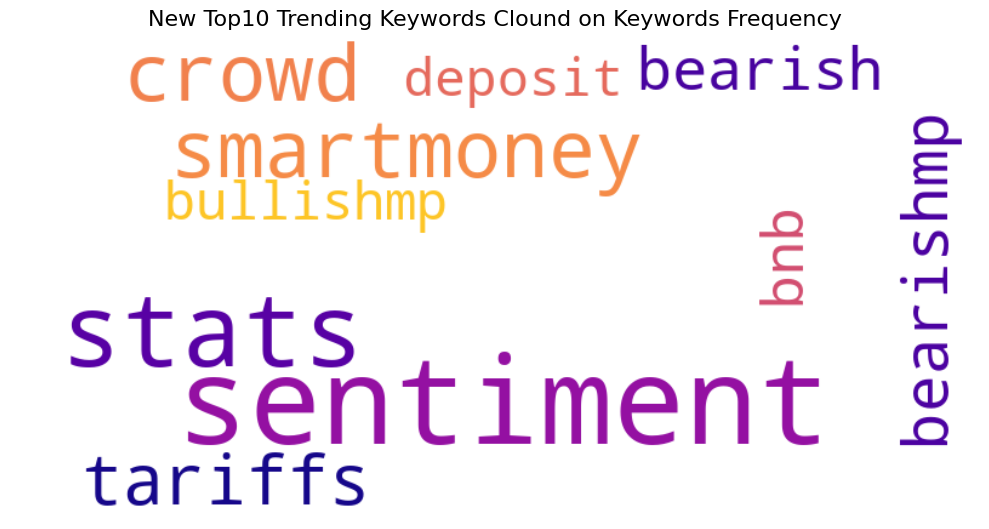

In [121]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# 1.  Build a word frequency dictionary
word_freq = dict(zip(df_top10_new['Keyword'], df_top10_new['Keyword Frequency']))

# 2. Build a word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='plasma',     # Optional viridis/ plasma / inferno / cool / cividis etc.
    max_font_size=100,
    prefer_horizontal=0.9,
    relative_scaling=0.5
).generate_from_frequencies(word_freq)

# 3. Show word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("New Top10 Trending Keywords Clound on Keywords Frequency", fontsize=16)
plt.tight_layout()
plt.show()


### Top10 Rapidly Rising Keywords

In [114]:
#Filter out rows where 'Keyword Frequency (Last Period)' is 0
df_up = df_sorted[df_sorted['Keyword Frequency (Last Period)'] > 0]

# Take the top 10 data of 'keyword frequency' (indicates Top Rapidly Rising Keywords this week)
df_top10_up = df_up.sort_values(by='Keyword Frequency Growth Rate', ascending=False).head(10)

# 打印查看结果
print(df_top10_up)
df_top10_up.to_excel('top10_up_keywords.xlsx', index=False)


    Keyword Keyword Frequency  \
12    trade                55   
0    crypto               328   
8   bullish                75   
7        ai                75   
1   bitcoin               261   
13    chain                55   
40  network                30   
33   wallet                32   
9     trump                69   
18   tokens                41   

                              Top 10 Comment Keywords  \
12  [(trade, 28), (tariffs, 20), (least, 20), (lin...   
0   [(crypto, 204), (sentiment, 185), (cryptos, 13...   
8   [(sentiment, 38), (crypto, 28), (cryptos, 24),...   
7   [(ai, 65), (sonic, 16), (bitcoin, 10), (decent...   
1   [(bitcoin, 183), (crypto, 42), (btc, 40), (ana...   
13  [(chain, 41), (abstraction, 27), (ai, 12), (ca...   
40  [(network, 6), (rewards, 4), (without, 4), (ev...   
33  [(wallet, 11), (want, 6), (liquidity, 6), (mov...   
9   [(trump, 37), (tariffs, 19), (crypto, 16), (ta...   
18  [(tokens, 33), (launchpad, 14), (crazy, 8), (b...   

   Numbe

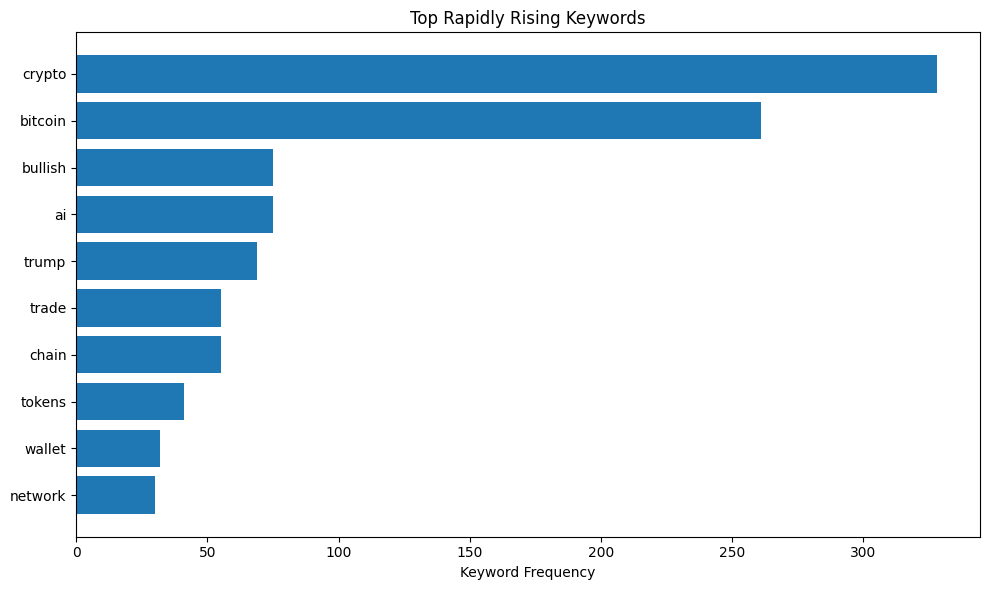

In [115]:
import matplotlib.pyplot as plt

df_plot = df_top10_up.sort_values(by='Keyword Frequency', ascending=False)

keywords = df_plot['Keyword']
frequencies = df_plot['Keyword Frequency']

plt.figure(figsize=(10, 6))
plt.barh(keywords, frequencies)
plt.xlabel("Keyword Frequency")
plt.title("Top Rapidly Rising Keywords")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


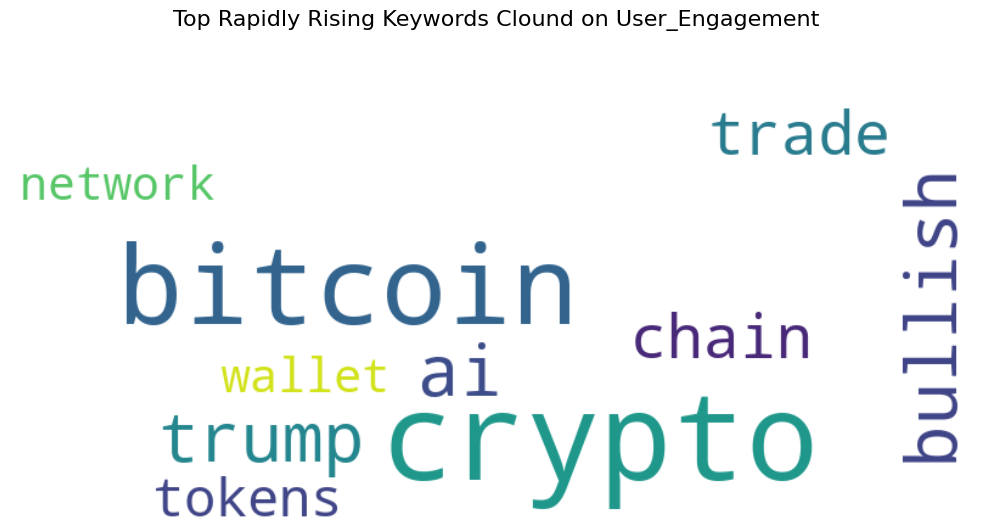

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_font_size=100,
    min_font_size=10,
    prefer_horizontal=0.9,    
    relative_scaling=0.5,      
    margin=1                 
).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Rapidly Rising Keywords Clound on User_Engagement", fontsize=16) #New Top10 Trending Keywords Clound on User_Engagement
plt.tight_layout(pad=1)
plt.show()


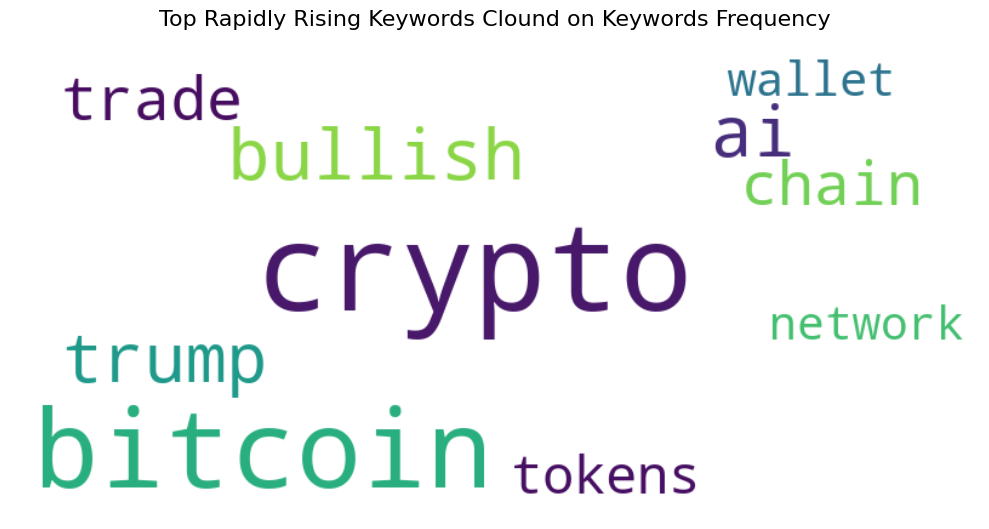

In [123]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


word_freq = dict(zip(df_top10_up['Keyword'], df_top10_up['Keyword Frequency']))


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',   
    max_font_size=100,
    prefer_horizontal=0.9,
    relative_scaling=0.5
).generate_from_frequencies(word_freq)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Rapidly Rising Keywords Clound on Keywords Frequency", fontsize=16)
plt.tight_layout()
plt.show()
